In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import pandas as pd
from scipy.io import loadmat
from utils import default_paths, prf_utils, nsd_utils
from model_fitting import initialize_fitting
from feature_extraction import fwrf_features

In [43]:
from feature_extraction import gabor_feature_extractor

n_ori=12; n_sf=8;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)
spat_kernels = _gabor_ext_complex.filter_stack

screen_eccen_deg=8.4

sf_cyc_per_stim = np.array(_gabor_ext_complex.feature_table['SF: cycles per stim'])
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = np.array(_gabor_ext_complex.feature_table['Orientation: degrees'])
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)

orient_filters_complex = np.real(_gabor_ext_complex.filter_stack)

In [8]:
# Load information about the sketch tokens features
from utils import default_paths
import scipy.stats
import pandas as pd
from scipy.io import loadmat

cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]
feature_ims = np.moveaxis(feature_ims, [0,1,2], [1,0,2])

fn = os.path.join(default_paths.sketch_token_feat_path,\
                  'Sketch_token_feature_curvrect_stats.npy')
stats = np.load(fn, allow_pickle=True).item()
c_means1 = np.mean(np.mean(stats['curv_score_method1'], axis=0), axis=0)
l_means1 = np.mean(np.mean(stats['lin_score_method1'], axis=0), axis=0)

curv_score = scipy.stats.zscore(c_means1)
lin_score = scipy.stats.zscore(l_means1)

dfname = os.path.join(default_paths.sketch_token_feat_path, \
                      'Sketch_tokens_info_table.csv')
df = pd.read_csv(dfname)

estim_bend_values = np.round(np.array(df['best_bend']),4)
estim_orient_values = np.round(np.array(df['best_orient']*180/np.pi),2)
best_linear_index = np.array(df['best_linear_index'])
best_curv_index = np.array(df['best_curv_index'])
which_best = np.array(df['which_best'])

is_single = df['single']
is_straight_line = is_single & (estim_bend_values==0)
is_curved_line = is_single & (estim_bend_values>0)

is_junction = df['junction']
is_double = df['double']
is_other = df['other']

feature_groups = [is_straight_line, is_curved_line, is_double, is_junction, is_other]
feature_group_names = ['straight line', 'curved line', 'double line', 'junction', 'other']

n_features = 150
which_group = np.array([np.where(np.array(feature_groups)[:,ii])[0][0] \
                        for ii in range(n_features)])

freq_values_cyc_per_image = np.linspace(2,7,4)
bend_values = np.round(np.linspace(0, 0.30, 8),4)
orient_values = np.linspace(0,360,73)[0:72]
orient_values = orient_values[0:36]; # simplify by assuming 180/360 are same
# n_ori = len(orient_values)
n_bend = len(bend_values)

In [34]:
# compute the highest and lowest frequencies that can be theoretically detected with 
# sketch tokens features
patch_size = 31;
highest_freq_cyc_per_pix = 1/2
lowest_freq_cyc_per_pix = 1/patch_size
lowest_freq_cyc_per_pix

st_freq_range_cyc_per_pix = np.array([lowest_freq_cyc_per_pix, highest_freq_cyc_per_pix] )
st_freq_range_cyc_per_image = st_freq_range_cyc_per_pix * 240
st_freq_range_cyc_per_degree = st_freq_range_cyc_per_image / 8.4

In [35]:
st_freq_range_cyc_per_degree

array([ 0.92165899, 14.28571429])

In [36]:
# note the lowest freq Gabor features are below the lowest freq detectable
# with sketch tokens
gabor_channels_use = np.where(sf_cyc_per_deg>=st_freq_range_cyc_per_degree[0])
sf_use = sf_unique[sf_unique>=st_freq_range_cyc_per_degree[0]]
n_sf_use = len(sf_use)

In [37]:
prf_models = initialize_fitting.get_prf_models(which_grid=5)
angle, eccen = prf_utils.cart_to_pol(prf_models[:,0]*8.4, prf_models[:,1]*8.4)
angle = np.round(angle,1)
eccen = np.round(eccen,2)
size = np.round(prf_models[:,2]*8.4,2)
aa = np.unique(angle)[14];
ee = np.unique(eccen)[3];
# ss = np.unique(size)[4];
ss = np.unique(size)[0];
mm = np.where((angle==aa) & (eccen==ee) & (size==ss))[0][0]
mm

62

In [46]:
mm = 378

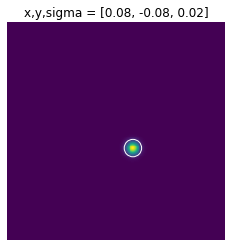

In [16]:
x,y,sigma = prf_models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)


plt.figure();
ax = plt.subplot(1,1,1)
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
ax.add_artist(circ)

In [19]:
subject =1
which_prf_grid=5 
feat_loader = fwrf_features.fwrf_feature_loader(subject=subject,\
                                which_prf_grid=which_prf_grid, \
                                feature_type='sketch_tokens',\
                                use_pca_feats = False, prf_batch_size=1)
inds_load = np.arange(1000) 
feat, _ = feat_loader.load(inds_load, prf_model_index=mm)

Loading pre-computed features for models [62 - 62] from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_grid5.h5py
Took 1.30373 seconds to load file
Size of features array for this image set is:
(1000, 150, 1)
Index into batch for prf 62: 0
Size of features array for this image set and prf is:
(1000, 150)
Final size of feature matrix is:
(1000, 150)


In [20]:
subject =1
which_prf_grid=5
feat_loader_gabor = fwrf_features.fwrf_feature_loader(subject=subject,\
                                which_prf_grid=which_prf_grid, \
                                feature_type='gabor_solo',\
                                n_ori=12, n_sf=8, nonlin=True, \
                                prf_batch_size=1)
inds_load = np.arange(1000) 
feat_gabor, _ = feat_loader_gabor.load(inds_load, prf_model_index=mm)

Loading pre-computed features for models [62 - 62] from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_12ori_8sf_gabor_solo_nonlin_grid5.h5py
Took 9.29787 seconds to load file
Size of features array for this image set is:
(1000, 96, 1)
Index into batch for prf 62: 0
Size of features array for this image set and prf is:
(1000, 96)
Final size of feature matrix is:
(1000, 96)


In [21]:
sum_gabor_feats = np.sum(feat_gabor, axis=1)
sum_st_feats = np.sum(feat, axis=1)

In [22]:
corr_with_gabor_sum = np.array([np.corrcoef(feat[:,st], sum_gabor_feats)[0,1] for st in range(150)])

In [23]:
gabor_indiv_corr_with_gabor_sum = \
    np.array([np.corrcoef(feat_gabor[:,gg], \
                          np.sum(feat_gabor[:,np.arange(0,96)!=gg], axis=1))[0,1] for gg in range(96)])

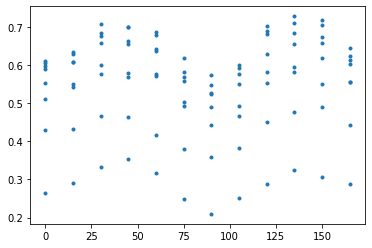

In [135]:
plt.figure();
plt.plot(ori_deg, gabor_indiv_corr_with_gabor_sum,'.')

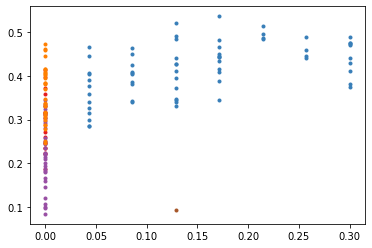

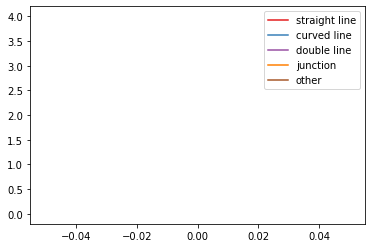

In [123]:
plt.figure();

from matplotlib import cm
colors = cm.Set1(np.linspace(0,1,7))

for ii, inds in enumerate(feature_groups):

    plt.plot(estim_bend_values[inds], corr_with_gabor_sum[inds],'.',color=colors[ii,:])
    
plt.figure()
for ii in range(5):
    plt.plot(0,ii,color=colors[ii,:])
plt.legend(feature_group_names)

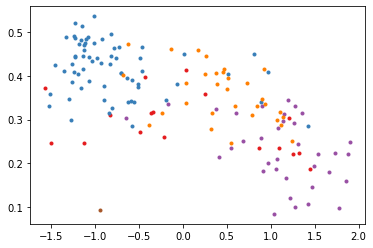

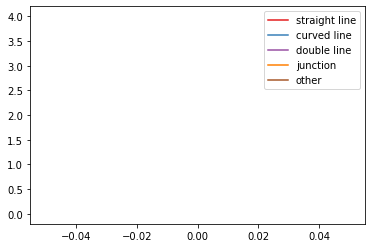

In [125]:
plt.figure();

from matplotlib import cm
colors = cm.Set1(np.linspace(0,1,7))

for ii, inds in enumerate(feature_groups):

    plt.plot(lin_score[inds], corr_with_gabor_sum[inds],'.',color=colors[ii,:])
    
plt.figure()
for ii in range(5):
    plt.plot(0,ii,color=colors[ii,:])
plt.legend(feature_group_names)

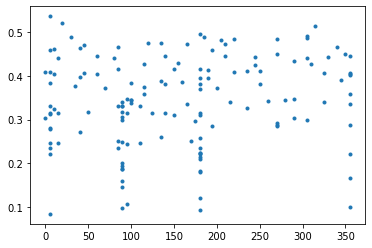

In [121]:
plt.figure();
plt.plot(estim_orient_values, corr_with_gabor_sum,'.')

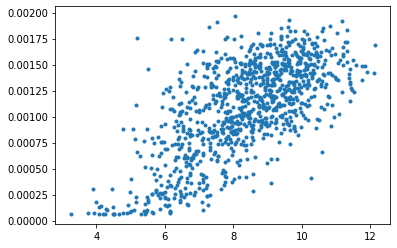

In [117]:
plt.figure();
plt.plot(sum_gabor_feats, sum_st_feats, '.')

Text(0.5, 0.98, 'sketch tokens feature 37\nori=45.0, bend=0.3000')

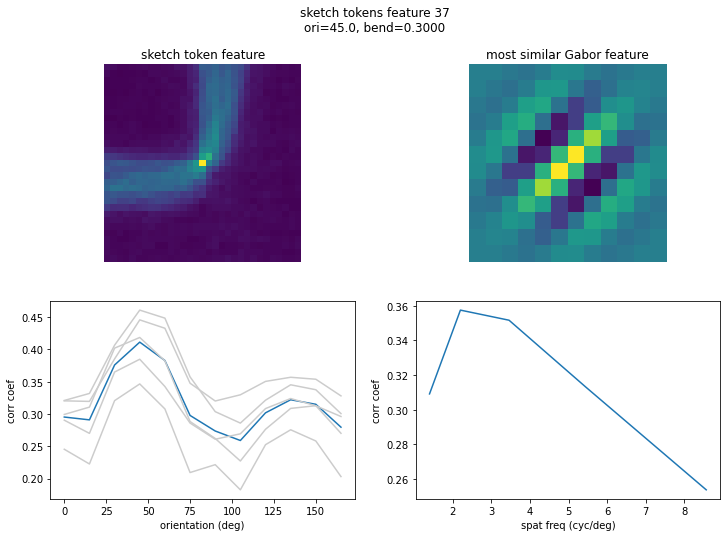

In [48]:
st_chan=37
# st_chan = 29;

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
plt.pcolormesh(feature_ims[:,:,st_chan])
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('sketch token feature')

corr_each = np.array([np.corrcoef(feat[:,st_chan], feat_gabor[:,g_chan])[0,1] \
                      for g_chan in range(96)])
max_orient_ind = np.mod(np.argmax(corr_each), n_ori)

corr_each = corr_each[gabor_channels_use]

plt.subplot(2,2,2)

feature_im = orient_filters_complex[max_orient_ind,0,:,:]
plt.pcolormesh(feature_im)
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('most similar Gabor feature')

corr_each_reshaped = np.reshape(corr_each, [n_ori, n_sf_use], order='F')
plt.subplot(2,2,3)
plt.plot(ori_unique,np.mean(corr_each_reshaped, axis=1))
plt.plot(ori_unique,corr_each_reshaped, color=[0.8, 0.8, 0.8])
plt.xlabel('orientation (deg)')
plt.ylabel('corr coef')

plt.subplot(2,2,4)
plt.plot(sf_use,np.mean(corr_each_reshaped, axis=0))
plt.xlabel('spat freq (cyc/deg)')
plt.ylabel('corr coef')

plt.suptitle('sketch tokens feature %d\nori=%.1f, bend=%.4f'\
             %(st_chan, estim_orient_values[st_chan], estim_bend_values[st_chan]))

Text(0.5, 0.98, 'sketch tokens feature 29\nori=50.0, bend=0.0000')

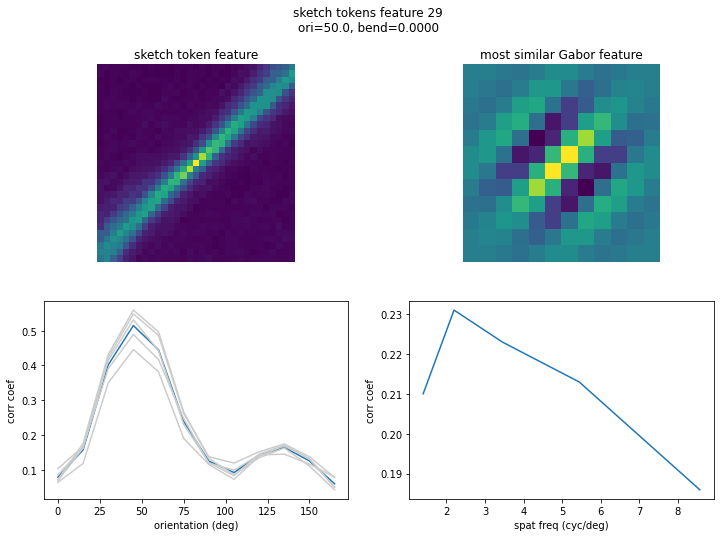

In [47]:
# st_chan=37
st_chan = 29;

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
plt.pcolormesh(feature_ims[:,:,st_chan])
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('sketch token feature')

corr_each = np.array([np.corrcoef(feat[:,st_chan], feat_gabor[:,g_chan])[0,1] \
                      for g_chan in range(96)])
max_orient_ind = np.mod(np.argmax(corr_each), n_ori)

corr_each = corr_each[gabor_channels_use]

plt.subplot(2,2,2)

feature_im = orient_filters_complex[max_orient_ind,0,:,:]
plt.pcolormesh(feature_im)
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('most similar Gabor feature')

corr_each_reshaped = np.reshape(corr_each, [n_ori, n_sf_use], order='F')
plt.subplot(2,2,3)
plt.plot(ori_unique,np.mean(corr_each_reshaped, axis=1))
plt.plot(ori_unique,corr_each_reshaped, color=[0.8, 0.8, 0.8])
plt.xlabel('orientation (deg)')
plt.ylabel('corr coef')

plt.subplot(2,2,4)
plt.plot(sf_use,np.mean(corr_each_reshaped, axis=0))
plt.xlabel('spat freq (cyc/deg)')
plt.ylabel('corr coef')

plt.suptitle('sketch tokens feature %d\nori=%.1f, bend=%.4f'\
             %(st_chan, estim_orient_values[st_chan], estim_bend_values[st_chan]))

Text(0.5, 0.98, 'sketch tokens feature 17\nori=180.0, bend=0.0000')

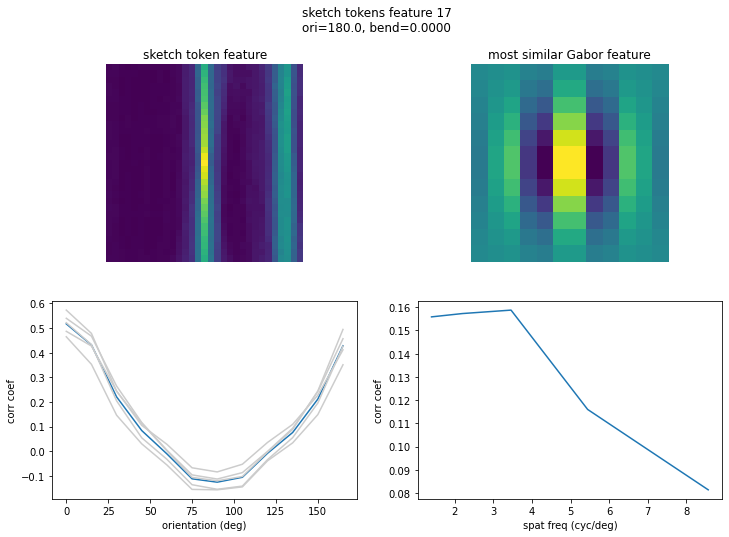

In [ ]:
st_chan = 17;

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
plt.pcolormesh(feature_ims[:,:,st_chan])
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('sketch token feature')

corr_each = np.array([np.corrcoef(feat[:,st_chan], feat_gabor[:,g_chan])[0,1] \
                      for g_chan in range(96)])
max_orient_ind = np.mod(np.argmax(corr_each), n_ori)

corr_each = corr_each[gabor_channels_use]

plt.subplot(2,2,2)

feature_im = orient_filters_complex[max_orient_ind,0,:,:]
plt.pcolormesh(feature_im)
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')
plt.title('most similar Gabor feature')

corr_each_reshaped = np.reshape(corr_each, [n_ori, n_sf_use], order='F')
plt.subplot(2,2,3)
plt.plot(ori_unique,np.mean(corr_each_reshaped, axis=1))
plt.plot(ori_unique,corr_each_reshaped, color=[0.8, 0.8, 0.8])
plt.xlabel('orientation (deg)')
plt.ylabel('corr coef')

plt.subplot(2,2,4)
plt.plot(sf_use,np.mean(corr_each_reshaped, axis=0))
plt.xlabel('spat freq (cyc/deg)')
plt.ylabel('corr coef')

plt.suptitle('sketch tokens feature %d\nori=%.1f, bend=%.4f'\
             %(st_chan, estim_orient_values[st_chan], estim_bend_values[st_chan]))